In [3]:
import pandas as pd; pd.set_option('display.max_columns', 25)
import numpy as np;
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns; 
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler as mms
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.manifold import TSNE
from tensorflow import keras
from keras import layers
from sklearn.cluster import DBSCAN
import pickle


df = pd.read_csv('genres_v2.csv', low_memory=False)
full_df = df
df = df.drop(['song_name', 'Unnamed: 0', 'title', 'analysis_url', 'track_href', 'uri', 'id', 'type'], axis=1)
df = df.sample(frac = 1).reset_index(drop=True) #Shuffling our data is crucial when it comes to modeling

features = ['danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms',]

df = df[features]
sc = StandardScaler()
sc.fit(df)
df_modified = sc.transform(df)

minmax_scaler = mms()
df_modified_2 = minmax_scaler.fit_transform(df)


In [ ]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples=100, random_state = 1, contamination= 'auto')
preds = clf.fit_predict(df_modified)
outliers2 = np.where(preds==-1)[0]

# t-SNE (Using both Scaled & Unscaled Data to compare)

1.2634719489930093
1.9617103269739504


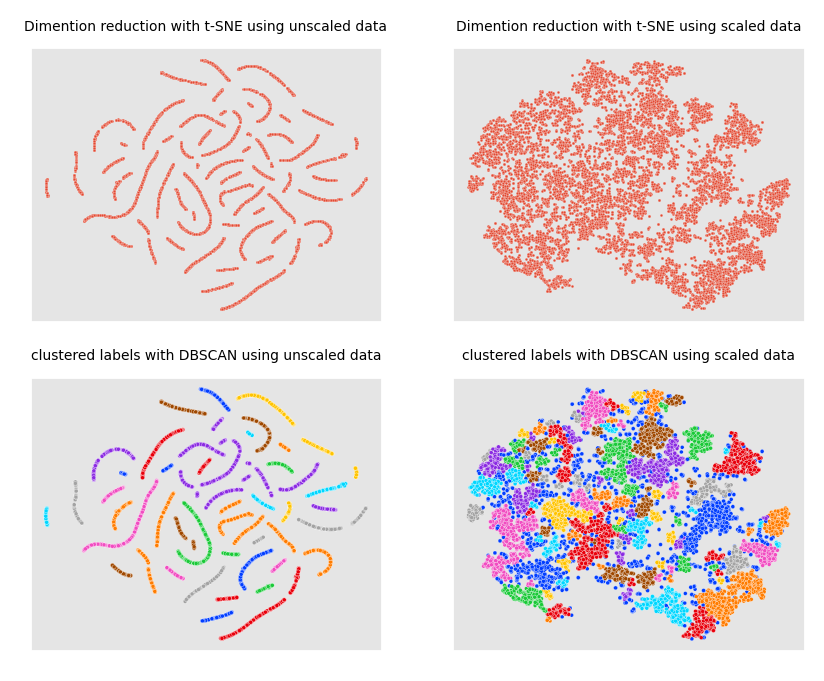

In [28]:
df_5k_unscaled = df[:10000]
tsne = TSNE(n_components=2, random_state=1, verbose=0, perplexity=20, n_iter=len(df_5k_unscaled))
tsne_df_unscaled = tsne.fit_transform(df_5k_unscaled)


df_5k_scaled = df_modified[:10000]
tsne = TSNE(n_components=2, random_state=1, verbose=0, perplexity=20, n_iter=len(df_5k_scaled))
tsne_df_scaled = tsne.fit_transform(df_5k_scaled)





dbscan_tsne_unscaled = DBSCAN(eps=15, min_samples=2).fit_predict(tsne_df_unscaled)
dbscan_tsne_scaled = DBSCAN(eps=4, min_samples=10).fit_predict(tsne_df_scaled)

fig, axes = plt.subplots(2, 2, dpi=200, figsize=(5, 4))
axes = axes.ravel()
for i in range(len(axes)) : 
    axes[i].yaxis.set_visible(False); axes[i].xaxis.set_visible(False);

sns.scatterplot(x=tsne_df_unscaled[:, 0], y=tsne_df_unscaled[:, 1], s=1, ax=axes[0])
sns.scatterplot(x=tsne_df_scaled[:, 0], y=tsne_df_scaled[:, 1], s=1, ax=axes[1]) 
axes[0].set_title('Dimention reduction with t-SNE using unscaled data', size=5)
axes[1].set_title('Dimention reduction with t-SNE using scaled data', size=5)

sns.scatterplot(x=tsne_df_unscaled[:, 0], y=tsne_df_unscaled[:, 1], s=2, hue=dbscan_tsne_unscaled, palette='bright', ax=axes[2])
sns.scatterplot(x=tsne_df_scaled[:, 0], y=tsne_df_scaled[:, 1], s=2, hue=dbscan_tsne_scaled, palette='bright', ax=axes[3]) 
axes[2].legend().set_visible(False);axes[2].set_title('clustered labels with DBSCAN using unscaled data', size=5)
axes[3].legend().set_visible(False);axes[3].set_title('clustered labels with DBSCAN using scaled data', size=5)

from sklearn.metrics import davies_bouldin_score
print(davies_bouldin_score(tsne_df_unscaled, dbscan_tsne_unscaled))
print(davies_bouldin_score(tsne_df_scaled, dbscan_tsne_scaled))

plt.show()

# PCA & FA (Using scaled data on PCA and Unscaled Data on FA)

In [ ]:
plt.figure(dpi=100)
pca = PCA(n_components=10)
pca_df = pca.fit_transform(df_modified)
sns.lineplot(x=range(1, 11), y=np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained Variance Ratio Of PCA with different n-components', size=10)

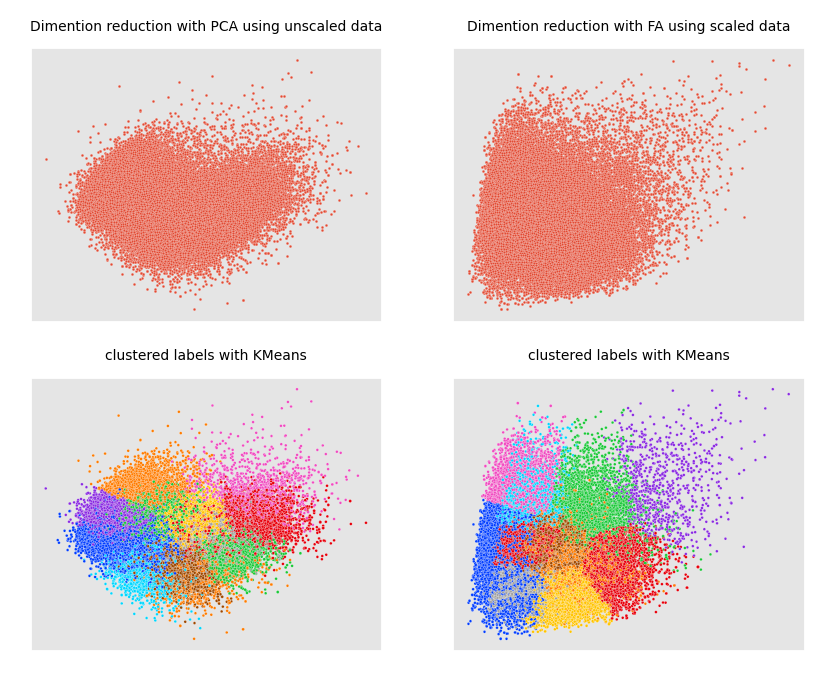

In [44]:

pca = PCA(n_components=4)
pca_df = pca.fit_transform(df_modified)



fa = FactorAnalysis(n_components=4, max_iter=10000, rotation='quartimax')
fa.fit(df_modified[:10000])
fa_df = fa.transform(df_modified)



from sklearn.cluster import KMeans

clusterer_pca = KMeans(14)
clusterer_pca.fit(pca_df)
cluster_pca = clusterer_pca.predict(pca_df)

clusterer_fa = KMeans(14)
clusterer_fa.fit(fa_df)
cluster_fa = clusterer_fa.predict(fa_df)

fig, axes = plt.subplots(2, 2, dpi=200, figsize=(5, 4))
axes = axes.ravel()
for i in range(len(axes)) : 
    axes[i].yaxis.set_visible(False); axes[i].xaxis.set_visible(False)

sns.scatterplot(x=pca_df[:, 0], y=pca_df[:, 1], s=1, ax=axes[0])
sns.scatterplot(x=fa_df[:, 0], y=fa_df[:, 1], s=1, ax=axes[1]) 
axes[0].set_title('Dimention reduction with PCA using unscaled data', size=5)
axes[1].set_title('Dimention reduction with FA using scaled data', size=5)

sns.scatterplot(x=pca_df[:, 0], y=pca_df[:, 1], s=1, hue=cluster_pca, palette='bright', ax=axes[2])
sns.scatterplot(x=fa_df[:, 0], y=fa_df[:, 1], s=1, hue=cluster_fa, palette='bright', ax=axes[3]) 
axes[2].legend().set_visible(False);axes[2].set_title('clustered labels with KMeans', size=5)
axes[3].legend().set_visible(False);axes[3].set_title('clustered labels with KMeans', size=5)

plt.show()




## adding the results to our database and pickling the models for later use
for i in range(4) : 
    col = 'pca_' + str(i+1)
    full_df[col] = pca_df[:, i]

for i in range(4) : 
    col = 'fa_' + str(i+1)
    full_df[col] = fa_df[:, i]

full_df['pca_labels'] = cluster_pca
full_df['fa_labels'] = cluster_fa

pickle.dump(sc, open('sc_scaler', 'wb'))
pickle.dump(pca, open('pca_model', 'wb'))
pickle.dump(fa, open('fa_model', 'wb'))
pickle.dump(clusterer_pca, open('pca_model_clusterer', 'wb'))
pickle.dump(clusterer_fa, open('fa_model_clusterer', 'wb'))





# Auto Encoder Alone

Train on 38074 samples, validate on 4231 samples
Epoch 1/20
38074/38074 [==============================] - 1s 28us/sample - loss: 0.3221 - val_loss: 0.0360
Epoch 2/20
   64/38074 [..............................] - ETA: 1s - loss: 0.0359

C:\Users\Soroush\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


38074/38074 [==============================] - 1s 19us/sample - loss: 0.0344 - val_loss: 0.0328
Epoch 3/20
38074/38074 [==============================] - 1s 19us/sample - loss: 0.0315 - val_loss: 0.0297
Epoch 4/20
38074/38074 [==============================] - 1s 18us/sample - loss: 0.0278 - val_loss: 0.0256
Epoch 5/20
38074/38074 [==============================] - 1s 19us/sample - loss: 0.0238 - val_loss: 0.0223
Epoch 6/20
38074/38074 [==============================] - 1s 16us/sample - loss: 0.0210 - val_loss: 0.0197
Epoch 7/20
38074/38074 [==============================] - 1s 16us/sample - loss: 0.0185 - val_loss: 0.0180
Epoch 8/20
38074/38074 [==============================] - 1s 16us/sample - loss: 0.0174 - val_loss: 0.0171
Epoch 9/20
38074/38074 [==============================] - 1s 15us/sample - loss: 0.0166 - val_loss: 0.0163
Epoch 10/20
38074/38074 [==============================] - 1s 14us/sample - loss: 0.0158 - val_loss: 0.0156
Epoch 11/20
38074/38074 [======================

INFO:tensorflow:Assets written to: ae_model\assets


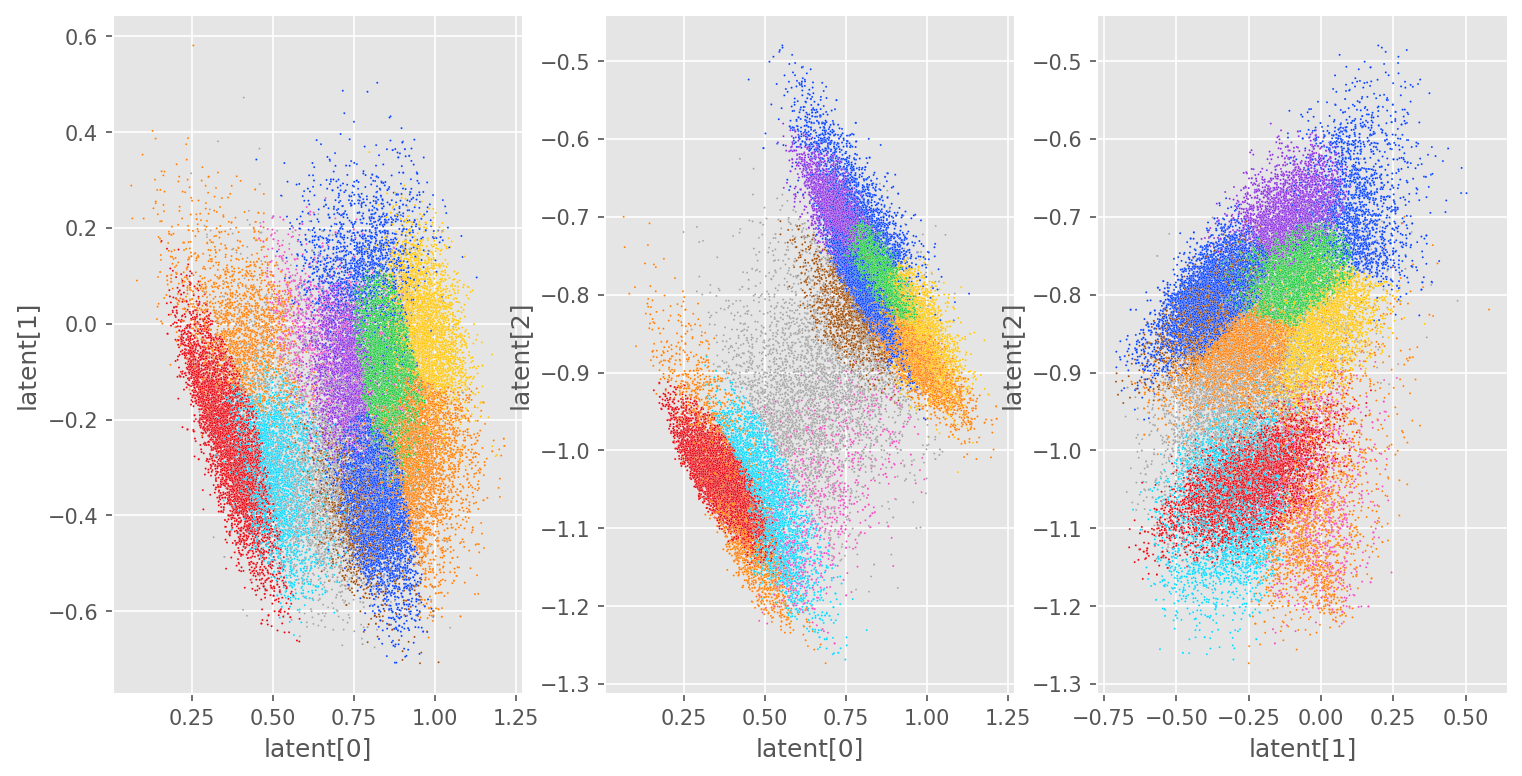

In [60]:
from tensorflow import keras
from keras import layers
import keras.optimizers as opts



inputed = keras.Input(shape=(10,))
encoded0 = layers.Dense(10, activation=None)(inputed)
#batcher0 = layers.BatchNormalization()(encoded0)
encoded1 = layers.Dense(7, activation='tanh')(encoded0)
encoded2 = layers.Dense(3, activation=None)(encoded1)
decoded1 = layers.Dense(7, activation='tanh')(encoded2)
#batcher1 = layers.BatchNormalization()(decoded1)
decoded2 = layers.Dense(10, activation=None)(decoded1)

autoencoder = keras.Model(inputed, decoded2)

autoencoder.compile(optimizer='adam', loss='MSE')
autoencoder.fit(df_modified_2, df_modified_2, epochs=20, batch_size=64, shuffle=False, verbose=1, validation_split=0.1)

encoder = keras.Model(inputed, encoded2)

ae_df = encoder.predict(df_modified_2)

ae_clusterer = GaussianMixture(12)
ae_clusterer.fit(ae_df)
labels = ae_clusterer.predict(ae_df)
fig, axes = plt.subplots(1, 3, dpi=150, figsize=(12, 6))
sns.scatterplot(x=ae_df[:, 0], y=ae_df[:, 1], s=1, hue=labels, palette='bright', ax=axes[0]); axes[0].set_xlabel('latent[0]'); axes[0].set_ylabel('latent[1]'); axes[0].legend().set_visible(False)
sns.scatterplot(x=ae_df[:, 0], y=ae_df[:, 2], s=1, hue=labels, palette='bright', ax=axes[1]); axes[1].set_xlabel('latent[0]'); axes[1].set_ylabel('latent[2]'); axes[1].legend().set_visible(False)
sns.scatterplot(x=ae_df[:, 1], y=ae_df[:, 2], s=1, hue=labels, palette='bright', ax=axes[2]); axes[2].set_xlabel('latent[1]'); axes[2].set_ylabel('latent[2]'); axes[2].legend().set_visible(False)


encoder.save('ae_model')
pickle.dump(ae_clusterer, open('ae_model_clusterer', 'wb'))

for i in range(3) : 
    col = 'ae_' + str(i+1)
    full_df[col] = ae_df[:, i]
full_df['ae_labels'] = labels


# AutoEncders & t-SNE

C:\Users\Soroush\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


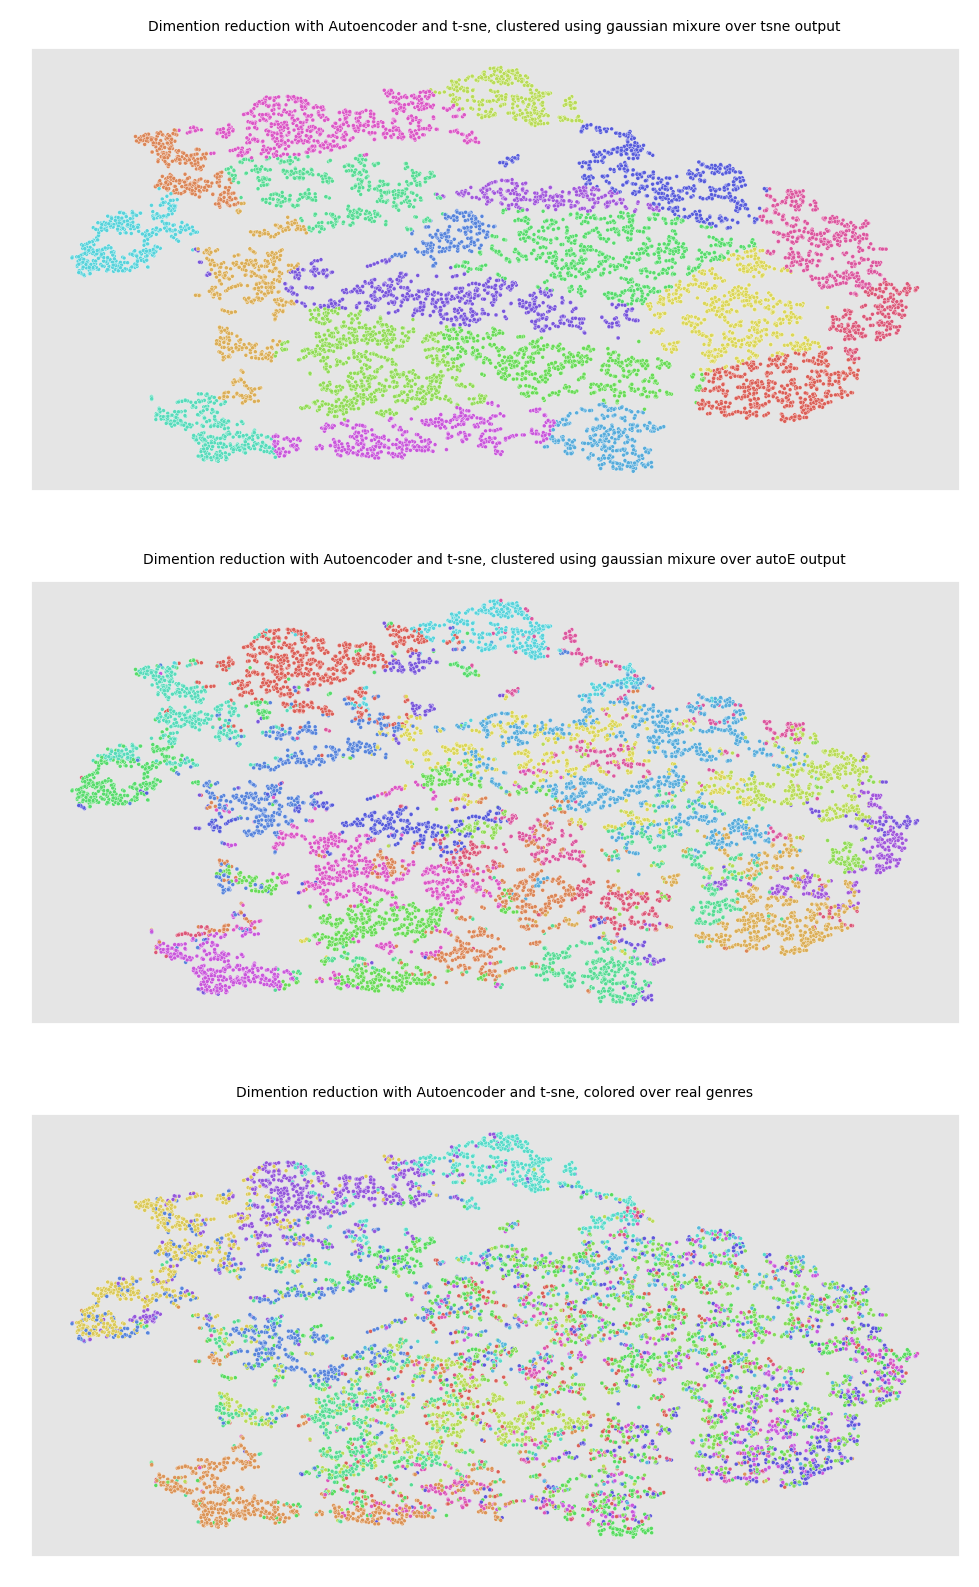

In [69]:
from tensorflow import keras
from keras import layers
import keras.optimizers as opts

df_train = df_modified[:10000]

inputed = keras.Input(shape=(10,))
encoded0 = layers.Dense(10, activation='tanh')(inputed)
encoded1 = layers.Dense(7, activation='Softmax')(encoded0)
encoded2 = layers.Dense(5, activation=None)(encoded1)
decoded1 = layers.Dense(7, activation='tanh')(encoded2)
decoded2 = layers.Dense(10, activation=None)(decoded1)

autoencoder = keras.Model(inputed, decoded2)

autoencoder.compile(optimizer='adam', loss='MSE')
autoencoder.fit(df_train, df_train, epochs=50, batch_size=64, shuffle=False, verbose=0)

decoder = keras.Model(inputed, encoded2)
ae_df = decoder.predict(df_train)



tsne = TSNE(n_components=2, random_state=1, verbose=0, perplexity=27, n_iter=len(ae_df))
ae_fa_df = tsne.fit_transform(ae_df)



from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import LabelEncoder as le

labels1 = GaussianMixture(n_components=20).fit_predict(ae_fa_df)
labels2 = GaussianMixture(n_components=20).fit_predict(ae_df)
labels3 = full_df[:10000].genre

fig, axes = plt.subplots(3, 1, dpi=200, figsize=(6, 10))
axes = axes.ravel()
for i in range(len(axes)) : 
    axes[i].yaxis.set_visible(False); axes[i].xaxis.set_visible(False)

palette1 = sns.color_palette("hls", 20); palette2 = sns.color_palette("hls", full_df.genre.nunique())
sns.scatterplot(x=ae_fa_df[:, 0], y=ae_fa_df[:, 1], s=2, hue=labels1, ax=axes[0], palette=palette1)
axes[0].set_title('Dimention reduction with Autoencoder and t-sne, clustered using gaussian mixure over tsne output', size=5); axes[0].legend().set_visible(False)
sns.scatterplot(x=ae_fa_df[:, 0], y=ae_fa_df[:, 1], s=2, hue=labels2, ax=axes[1], palette=palette1)
axes[1].set_title('Dimention reduction with Autoencoder and t-sne, clustered using gaussian mixure over autoE output', size=5); axes[1].legend().set_visible(False)
sns.scatterplot(x=ae_fa_df[:, 0], y=ae_fa_df[:, 1], s=2, hue=labels3, ax=axes[2], palette=palette2)
axes[2].set_title('Dimention reduction with Autoencoder and t-sne, colored over real genres', size=5); axes[2].legend().set_visible(False)


<AxesSubplot:title={'center':'pc1 & pc2'}>

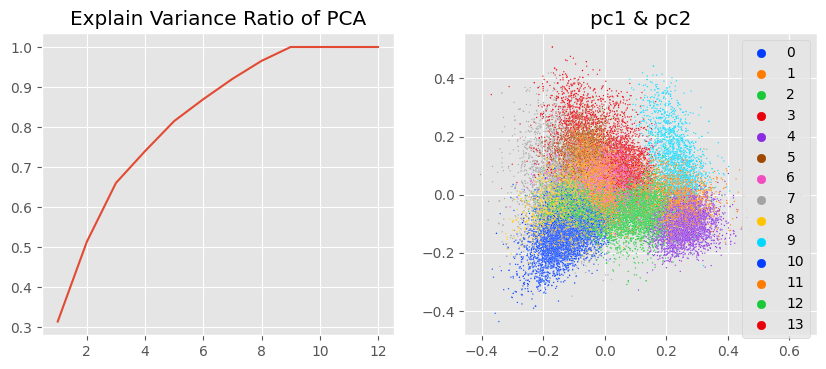

In [73]:
from tensorflow import keras
from keras import layers
import keras.optimizers as opts

df_train = df_modified[:10000]

inputed = keras.Input(shape=(10,))
encoded0 = layers.Dense(10, activation=None)(inputed)
encoded2 = layers.Dense(10, activation=None)(encoded0)

latent0 = layers.Dense(12, activation=None)(encoded2)

decoded0 = layers.Dense(10, activation='tanh')(latent0)
decoded2 = layers.Dense(12, activation='tanh')(decoded0)

latent1 = layers.Dense(14, activation=None)(decoded2)

decoded01 = layers.Dense(12, activation='tanh')(latent1)
decoded21 = layers.Dense(10, activation='tanh')(decoded01)

latent2 = layers.Dense(12, activation=None)(decoded21)

decoded02 = layers.Dense(10, activation=None)(latent2)
decoded22 = layers.Dense(10, activation=None)(decoded02)

autoencoder = keras.Model(inputed, decoded22)

autoencoder.compile(optimizer='adam', loss='MSE')
autoencoder.fit(df_modified, df_modified, epochs=15, batch_size=64, shuffle=False, verbose=1)

decoder = keras.Model(inputed, latent1)
ae_df = decoder.predict(df_train)
ae_df_full = decoder.predict(df_modified)


pca_2 = PCA(12).fit(ae_df_full)
fdf = pca_2.transform(ae_df_full)

fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10, 4), dpi=100)
axes[0].set_title('Explain Variance Ratio of PCA'); axes[1].set_title('pc1 & pc2')
sns.lineplot(x=range(1, 13), y=np.cumsum(pca_2.explained_variance_ratio_), ax=axes[0])

pca_2 = PCA(4).fit(ae_df_full)
fdf = pca_2.transform(ae_df_full)
labels2 = GaussianMixture(n_components=14).fit_predict(fdf)

sns.scatterplot(x=fdf[:, 0], y=fdf[:, 1], hue=labels2, palette='bright', s=1, ax=axes[1])






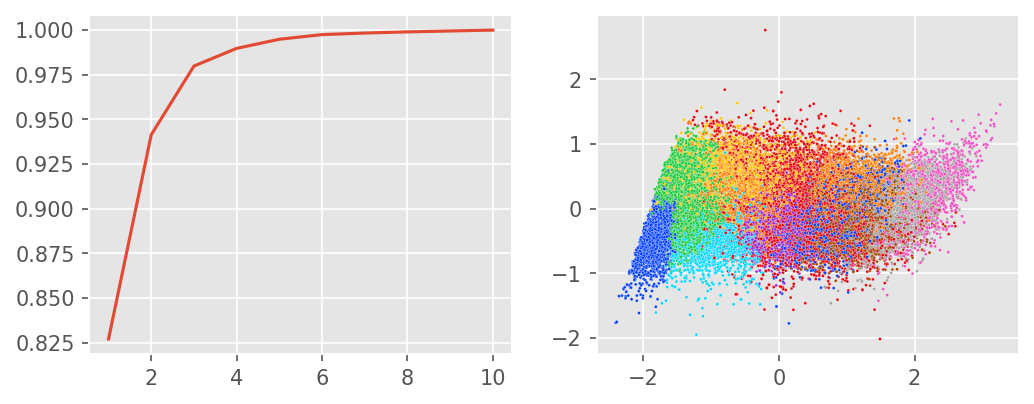

In [47]:
from scipy.stats import boxcox as bc
import pickle
from sklearn.preprocessing import MinMaxScaler as mms
from sklearn.mixture import GaussianMixture

minmax_scaler = mms()
df_modified_2 = minmax_scaler.fit_transform(df) + 1
df_linearized = pd.DataFrame()
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(8, 3), dpi=150)

for i in range(10):
    df_linearized[str(i)] = bc(df_modified_2[:, i])[0]

pca = PCA(10).fit(df_linearized)
fdf = pca.transform(df_linearized)
sns.lineplot(x=range(1, 11), y=np.cumsum(pca.explained_variance_ratio_), ax=axes[0])


bc_pca_model = PCA(4)
bc_pca_model.fit(df_linearized)
bc_pca_df = bc_pca_model.transform(df_linearized)

bc_pca_model_clusterer = GaussianMixture(n_components=14)
bc_pca_model_clusterer.fit(bc_pca_df)
labels_bc_pca = bc_pca_model_clusterer.predict(bc_pca_df)
sns.scatterplot(x=bc_pca_df[:, 0], y=bc_pca_df[:, 1], s=2, hue=labels_bc_pca, palette='bright', ax=axes[1]); plt.legend().set_visible(False)


pickle.dump(minmax_scaler, open('normal_scaler', 'wb'))
pickle.dump(bc, open('bc_pca_model_0', 'wb'))
pickle.dump(bc_pca_model, open('bc_pca_model_1', 'wb'))
pickle.dump(bc_pca_model_clusterer, open('bc_pca_model_clusterer', 'wb'))

for i in range(4) : 
    col = 'bc_pca_' + str(i+1)
    full_df[col] = bc_pca_df[:, i]

full_df['bc_pca_labels'] = labels_bc_pca

In [126]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
normal_df = mms.fit_transform(df)                      #### mms first pipe

import tensorflow
input_data = tensorflow.keras.layers.Input(shape=(10))
encoder = tensorflow.keras.layers.Dense(10, activation='tanh')(input_data)
encoder = tensorflow.keras.layers.Dense(8, activation='tanh')(encoder)

def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tensorflow.shape(distribution_variance)[0]
    random = tensorflow.keras.backend.random_normal(shape=(batch_size, tensorflow.shape(distribution_variance)[1]))
    return distribution_mean + tensorflow.exp(0.5 * distribution_variance) * random
 
distribution_mean = tensorflow.keras.layers.Dense(5, name='mean')(encoder)
distribution_variance = tensorflow.keras.layers.Dense(5, name='log_variance')(encoder)
latent_encoding = tensorflow.keras.layers.Lambda(sample_latent_features)([distribution_mean, distribution_variance])

encoder_model = tensorflow.keras.Model(input_data, latent_encoding)
#encoder_model.summary()


decoder_input = tensorflow.keras.layers.Input(shape=(5))
decoder = tensorflow.keras.layers.Dense(5, activation=None)(decoder_input)
decoder = tensorflow.keras.layers.Dense(8, activation='tanh')(decoder) 
decoder_output = tensorflow.keras.layers.Dense(10, activation='tanh')(decoder)


decoder_model = tensorflow.keras.Model(decoder_input, decoder_output)
#decoder_model.summary()


encoded = encoder_model(input_data)
decoded = decoder_model(encoded)
vautoencoder = tensorflow.keras.models.Model(input_data, decoded)
#autoencoder.summary()

def get_loss(distribution_mean, distribution_variance):
    
    def get_reconstruction_loss(y_true, y_pred):
        reconstruction_loss = tensorflow.keras.losses.mse(y_true, y_pred)
        reconstruction_loss_batch = tensorflow.reduce_mean(reconstruction_loss)
        return reconstruction_loss_batch*10
    
    def get_kl_loss(distribution_mean, distribution_variance):
        kl_loss = 1 + distribution_variance - tensorflow.square(distribution_mean) - tensorflow.exp(distribution_variance)
        kl_loss_batch = tensorflow.reduce_mean(kl_loss)
        return kl_loss_batch*(-0.5)
    
    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance)
        return reconstruction_loss_batch + kl_loss_batch
    
    return total_loss



vautoencoder.compile(loss=get_loss(distribution_mean, distribution_variance), optimizer='adam')

vautoencoder.fit(normal_df, normal_df, epochs=30, batch_size=64, validation_split=0.2)

Train on 33844 samples, validate on 8461 samples
Epoch 1/30
33472/33844 [============================>.] - ETA: 0s - loss: 0.8078

C:\Users\Soroush\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


33844/33844 [==============================] - 2s 66us/sample - loss: 0.8034 - val_loss: 0.4023
Epoch 2/30
33844/33844 [==============================] - 1s 29us/sample - loss: 0.3902 - val_loss: 0.3879
Epoch 3/30
33844/33844 [==============================] - 1s 28us/sample - loss: 0.3857 - val_loss: 0.3855
Epoch 4/30
33844/33844 [==============================] - 1s 32us/sample - loss: 0.3836 - val_loss: 0.3812
Epoch 5/30
33844/33844 [==============================] - 1s 28us/sample - loss: 0.3761 - val_loss: 0.3770
Epoch 6/30
33844/33844 [==============================] - 1s 28us/sample - loss: 0.3740 - val_loss: 0.3760
Epoch 7/30
33844/33844 [==============================] - 1s 28us/sample - loss: 0.3728 - val_loss: 0.3691
Epoch 8/30
33844/33844 [==============================] - 1s 28us/sample - loss: 0.3704 - val_loss: 0.3675
Epoch 9/30
33844/33844 [==============================] - 1s 29us/sample - loss: 0.3686 - val_loss: 0.3682
Epoch 10/30
33844/33844 [=======================

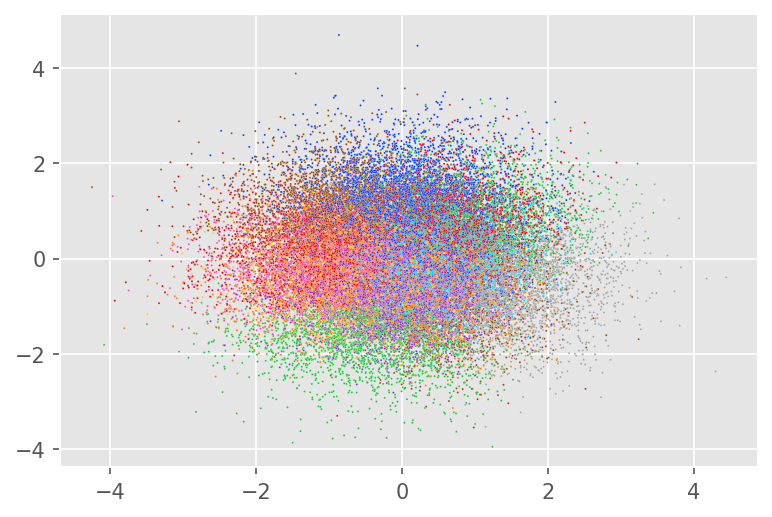

In [128]:
ans = encoder_model.predict(normal_df)
vae_pca = PCA(n_components=2)
ans_2 = vae_pca.fit_transform(ans)


plt.figure(dpi=150)
vae_clusterer = GaussianMixture(16)
vae_clusterer.fit(ans)
labels = vae_clusterer.predict(ans)

sns.scatterplot(x=ans_2[:, 0], y=ans_2[:, 1], s=1, hue=labels, palette='bright'); plt.legend().set_visible(False)




#encoder_model = tensorflow.keras.Model(input_data, latent_encoding)
encoder_model.save_weights('vae_model_weights')
pickle.dump(vae_clusterer, open('vae_model_clusterer', 'wb'))

for i in range(5) : 
    col = 'vae_' + str(i+1)
    full_df[col] = ans[:, i]

full_df['vae_labels'] = labels

C:\Users\Soroush\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Soroush\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Soroush\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword w

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'Dark Trap'),
  Text(1, 0, 'Underground Rap'),
  Text(2, 0, 'Trap Metal'),
  Text(3, 0, 'Emo'),
  Text(4, 0, 'Rap'),
  Text(5, 0, 'RnB'),
  Text(6, 0, 'Pop'),
  Text(7, 0, 'Hiphop'),
  Text(8, 0, 'techhouse'),
  Text(9, 0, 'techno'),
  Text(10, 0, 'trance'),
  Text(11, 0, 'psytrance'),
  Text(12, 0, 'trap'),
  Text(13, 0, 'dnb'),
  Text(14, 0, 'hardstyle')])

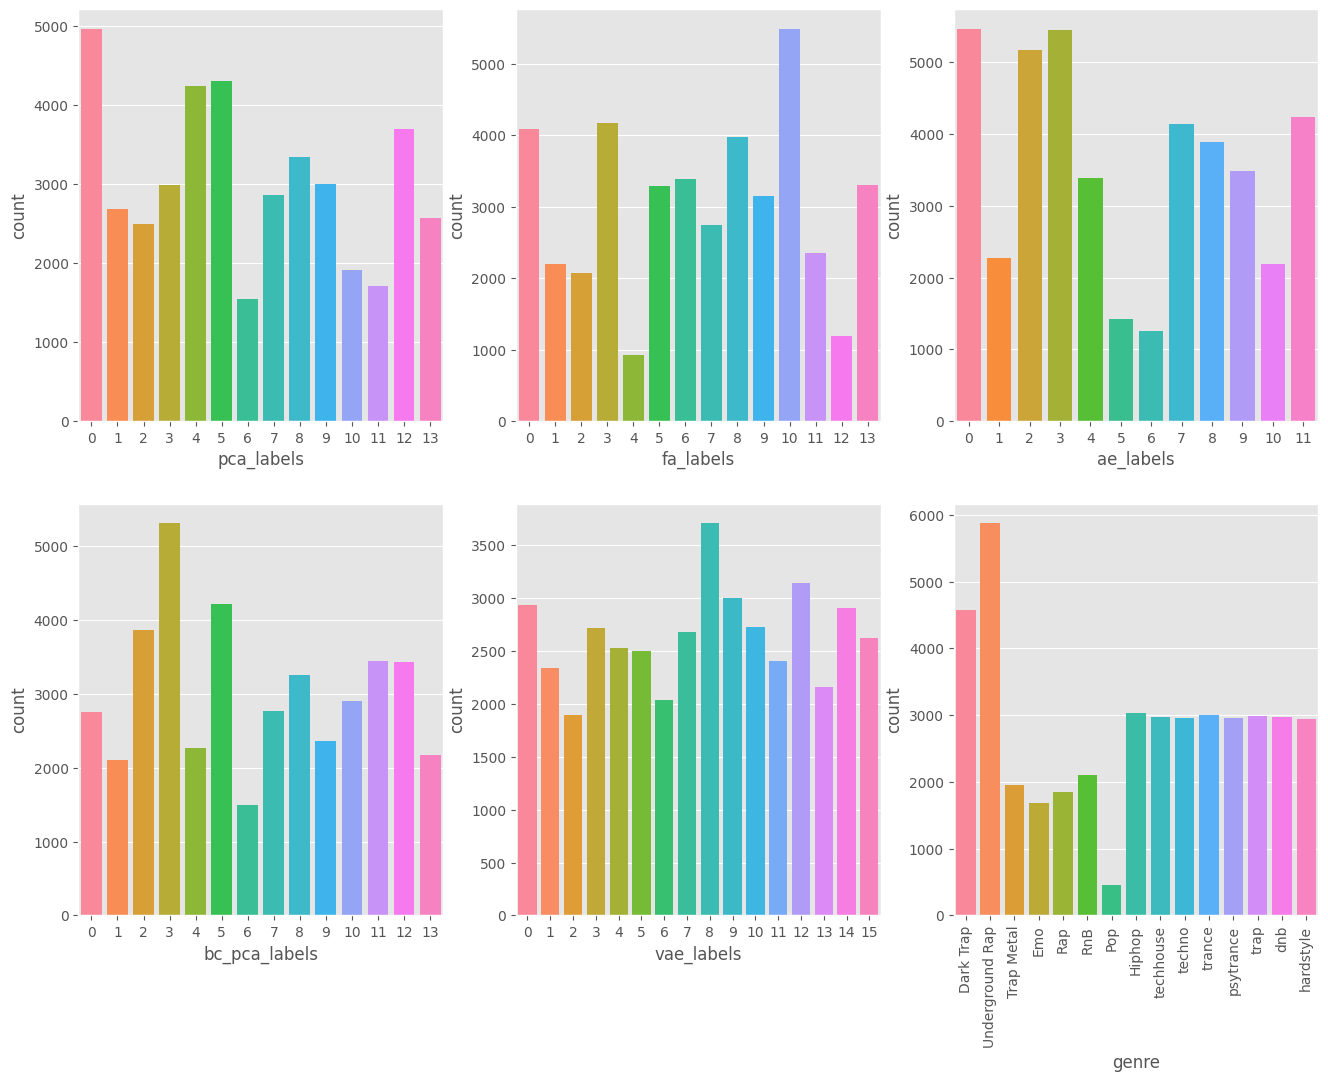

In [81]:
fig, axes = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(16, 12), dpi=100)
axes = axes.ravel()

sns.countplot(full_df.pca_labels, ax=axes[0], saturation=1)
sns.countplot(full_df.fa_labels, ax=axes[1], saturation=1)
sns.countplot(full_df.ae_labels, ax=axes[2], saturation=1)
sns.countplot(full_df.bc_pca_labels, ax=axes[3], saturation=1)
sns.countplot(full_df.vae_labels, ax=axes[4], saturation=1)
sns.countplot(full_df.genre, ax=axes[5], saturation=1); plt.xticks(rotation=90)